In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from scipy.stats import poisson
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve

import seaborn as sns
sns.set()

In [5]:
#VegasLines2015_2016['Date'] = pd.to_datetime(VegasLines2015_2016['Date'], format="%Y%m%d")

In [6]:
#nba_games_15_16 = nba_games_15_16.reset_index(drop=True)

In [7]:
#merge vegas lines into main df
#for row1, index1 in zip(nba_games_15_16.values, nba_games_15_16.index):
#    for row2, index2 in zip(VegasLines2015_2016.values, VegasLines2015_2016.index):
#        if row1[11] == row2[0] and row1[3] == row2[1]:
#            nba_games_15_16.loc[index1, 'VegasLine'] = row2[2]

In [8]:
#make a column for difference between final score and vegas line
#nba_games_15_16['FinalScore_VegasLine'] = nba_games_15_16['COMBINED_FINAL_SCORE']-nba_games_15_16['VegasLine']

In [9]:
#Make Home or away column
#Home is 1 Away is 0
#nba_games_15_16['HOMEAWAY'] = 0

#for row, index in zip(nba_games_15_16.values, nba_games_15_16.index):
#    if '@' in row[12]:
#        nba_games_15_16['HOMEAWAY'][index] = 1

In [10]:
#convert WL to 1,0
#nba_games_15_16.loc[nba_games_15_16.WL == 'W', 'WL'] = 1
#nba_games_15_16.loc[nba_games_15_16.WL == 'L', 'WL'] = 0

In [11]:
#make column where >finalscore-vegasline is 1 and < is -1 and = is 0
#nba_games_15_16['O/U'] = 0
#nba_games_15_16.loc[nba_games_15_16.FinalScore_VegasLine > 0, 'O/U'] = 1
#nba_games_15_16.loc[nba_games_15_16.FinalScore_VegasLine == 0, 'O/U'] = 0
#nba_games_15_16.loc[nba_games_15_16.FinalScore_VegasLine < 0, 'O/U'] = -1

In [12]:
#nba_games_15_16 = nba_games_15_16.dropna()
#nba_games_15_16 = nba_games_15_16.reset_index(drop = True)

In [144]:
stats = pd.read_csv('nba_stats_05-19.csv')

In [145]:
stats.head()

,date,team,points,op team,op points,total points,home away,season,vegas line,o/u margin,...,three pointers attempted,three pointers made,three pointer percentage,percentage of points from three pointers,time of game,time zone,times tied,turnovers,wins,win percentage
0,20051101,Pelicans,93,Kings,67,160,home,2005,7.5,-32.5,...,11.0,4.0,4.30,12.90,135.0,C,0.0,20.0,0,0.0
1,20051101,Kings,67,Pelicans,93,160,away,2005,-7.5,-32.5,...,13.0,3.0,4.48,13.43,135.0,P,0.0,18.0,0,0.0
2,20051101,Seventysixers,108,Bucks,117,225,home,2005,-7.0,26.0,...,12.0,4.0,3.70,11.11,135.0,E,0.0,8.0,0,0.0
3,20051101,Bucks,117,Seventysixers,108,225,away,2005,7.0,26.0,...,13.0,6.0,5.13,15.38,135.0,C,0.0,17.0,0,0.0
4,20051101,Spurs,102,Nuggets,91,193,home,2005,-7.5,3.5,...,13.0,4.0,3.92,11.76,135.0,C,0.0,14.0,0,0.0


In [146]:
stats.columns

Index(['date', 'team', 'points', 'op team', 'op points', 'total points',
       'home away', 'season', 'vegas line', 'o/u margin', 'vegas line total',
       'assists', 'ats margin', 'ats streak', 'attendance', 'biggest lead',
       'blocks', 'conference', 'day', 'defensive rebounds', 'division', 'dpa',
       'dps', 'fast break points', 'field goals attempted', 'field goals made',
       'percentage of points from field goals', 'field goal percentage',
       'fouls', 'free throws attempted', 'free throws made',
       'percentage of points from free throws', 'free throw percentage',
       'game number', 'lead changes', 'losses', 'margin',
       'margin after the first', 'margin after the third',
       'margin at the half', 'matchup losses', 'matchup wins',
       'offensive rebounds', 'officials', 'ou streak', 'overtime',
       'points in the paint', 'rebounds', 'rest', 'site streak', 'steals',
       'streak', 'team rebounds', 'three pointers attempted',
       'three pointers 

In [102]:
#make column where >=finalscore-vegasline is 1 and < is 0
stats['o/u'] = 0
stats.loc[stats['o/u margin'] >= 0, 'o/u'] = 1
stats.loc[stats['o/u margin'] < 0, 'o/u'] = 0

In [103]:
stats = stats.dropna()
stats = stats.reset_index(drop = True)

In [104]:
num_feat = stats.select_dtypes('number').columns.values
stats[num_feat].nunique().sort_values()

o/u                                            2
overtime                                       5
matchup wins                                   8
matchup losses                                 8
rest                                          11
season                                        15
blocks                                        20
site streak                                   21
steals                                        23
ou streak                                     25
team rebounds                                 26
times tied                                    27
ats streak                                    28
three pointers made                           28
turnovers                                     28
offensive rebounds                            33
fouls                                         38
lead changes                                  38
defensive rebounds                            44
assists                                       44
field goals made    

In [105]:
cat_feat = X.select_dtypes('object').columns.values
X[cat_feat].nunique().sort_values()

home away         2
conference        2
time zone         4
division          6
day               7
team             31
op team          31
officials     14295
dtype: int64

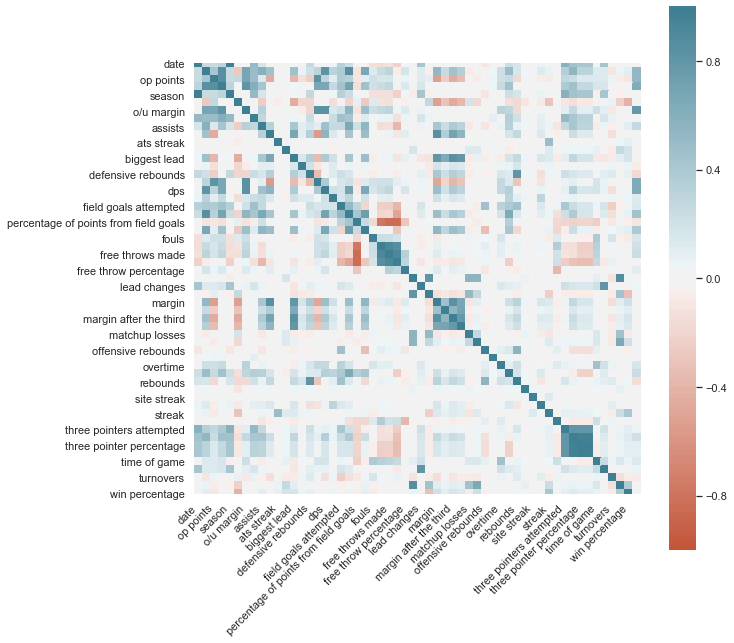

In [106]:
corr = stats.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [107]:
num_feat = stats.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(stats[comb[0]], stats[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [108]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['date', 'season'],
       ['free throws attempted', 'free throws made'],
       ['free throws made', 'percentage of points from free throws'],
       ['three pointers made', 'three pointer percentage'],
       ['three pointers made',
        'percentage of points from three pointers'],
       ['three pointer percentage',
        'percentage of points from three pointers']], dtype='<U40')

In [109]:
y = stats['o/u'].copy()

In [131]:
matchup = X[['team', 'op team']]
matchup['matchup'] = matchup['team'] + ' ' + matchup['op team']
matchup

,team,op team,matchup
0,Pelicans,Kings,Pelicans Kings
1,Kings,Pelicans,Kings Pelicans
2,Seventysixers,Bucks,Seventysixers Bucks
3,Bucks,Seventysixers,Bucks Seventysixers
4,Spurs,Nuggets,Spurs Nuggets
...,...,...,...
36161,Trailblazers,Knicks,Trailblazers Knicks
36162,Lakers,Suns,Lakers Suns
36163,Suns,Lakers,Suns Lakers
36164,Wizards,Magic,Wizards Magic


In [137]:
X = stats.copy()
X = X.dropna()
X = X.reset_index(drop = True)
X = X.drop(['o/u', 'o/u margin', 'vegas line', 'vegas line total', 'ats margin', 'dps', 'dpa', 'total points', 'points', 'op points', 'field goals made', 'field goal percentage'], axis=1, errors='ignore')
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(matchup['matchup'], y, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

In [138]:
X.head()

,date,team,op team,home away,season,assists,ats streak,attendance,biggest lead,blocks,...,three pointers attempted,three pointers made,three pointer percentage,percentage of points from three pointers,time of game,time zone,times tied,turnovers,wins,win percentage
0,20051101,Pelicans,Kings,home,2005,21.0,0,19163.0,28.0,4.0,...,11.0,4.0,4.30,12.90,135.0,C,0.0,20.0,0,0.0
1,20051101,Kings,Pelicans,away,2005,13.0,0,19163.0,7.0,5.0,...,13.0,3.0,4.48,13.43,135.0,P,0.0,18.0,0,0.0
2,20051101,Seventysixers,Bucks,home,2005,25.0,0,17705.0,9.0,7.0,...,12.0,4.0,3.70,11.11,135.0,E,0.0,8.0,0,0.0
3,20051101,Bucks,Seventysixers,away,2005,26.0,0,17705.0,11.0,3.0,...,13.0,6.0,5.13,15.38,135.0,C,0.0,17.0,0,0.0
4,20051101,Spurs,Nuggets,home,2005,21.0,0,18797.0,11.0,7.0,...,13.0,4.0,3.92,11.76,135.0,C,0.0,14.0,0,0.0


In [139]:
y_train.value_counts()

1    10270
0    10073
Name: o/u, dtype: int64

In [140]:
cat_feat_ind = (X_train.dtypes == 'object').nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=.03,
                           iterations=500,
                           early_stopping_rounds=100,
                           class_weights=[1, 1],
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True);

AttributeError: 'bool' object has no attribute 'nonzero'

Accuracy (test): 0.507
Precision (test): 0.507
Recall (test): 0.918


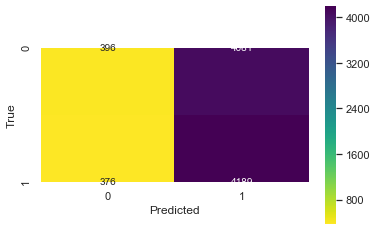

In [141]:
y_pred_test = model.predict(pool_test)

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

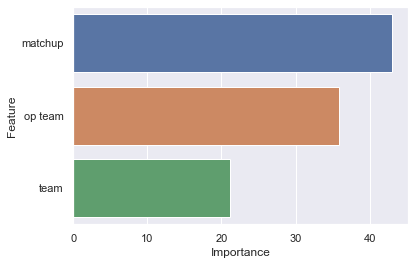

In [142]:
feat = model.feature_names_
imp = model.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:20]
sns.barplot(x='Importance', y='Feature', data=df);

In [26]:
#fig, ax = plt.subplots(1,1, figsize=(15,10))
#g = sns.boxplot(x='abbreviation', y='FinalScore_VegasLine', data=nba_games_15_16)
#g = sns.scatterplot(x=nba_games_15_16.index, y='FinalScore_VegasLine', data=nba_games_15_16)

In [27]:
#fig, ax = plt.subplots(1,1, figsize=(15,10))
#g = sns.boxplot(x='abbreviation', y='FinalScore_VegasLine', data=nba_games_15_16)

In [28]:
#nba_games_15_16.columns

In [29]:
#x = nba_games_15_16.copy()

In [30]:
#drop columns that are >l.8l correlated or not useful like state or team id
#cols_to_keep = ['MATCHUP', 'WL', 'MIN', 'PTS', 'FGA',
#       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FT_PCT', 'OREB',
#       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'FinalScore_VegasLine', 'HOMEAWAY', 'O/U']
#x = x[cols_to_keep]

In [31]:
#x.set_index('MATCHUP', inplace=True)
#x.head()

In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

dt = DecisionTreeRegressor()

# Grid search meta parameters
param_grid = dict(min_samples_leaf=np.array([1,5,10,50,100,200]), max_depth=np.array([2,4,6,8,10]))
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, Y)

# Evaluate best model
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
dt = DecisionTreeRegressor(**grid_result.best_params_)
scores = cross_val_score(dt, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print('CART')
print(scores.mean())

# Serialize tree structure for investigation
dt.fit(X, Y)
output_file = './auto_mpg.graphviz'
export_graphviz(dt, out_file=output_file, feature_names = X.columns)
print("Wrote output to " + output_file)

NameError: name 'KFold' is not defined

In [33]:
#fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
#for i, ax in enumerate(axes.flatten()):
#    sns.barplot(x='TEAM_ABBREVIATION', y=x.columns[i+1], data=x, hue='O/U', ax=ax)

In [34]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(x)
x_scaled_array = scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled_array, columns = x.columns)

x_scaled.shape

NameError: name 'x' is not defined

In [35]:
from sklearn.cluster import KMeans

nclusters = 3 # this is the k in kmeans
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(x_scaled)

# predict the cluster for each data point
y_cluster_kmeans = km.predict(x_scaled)
y_cluster_kmeans

NameError: name 'x_scaled' is not defined

In [36]:
from sklearn import metrics
score = metrics.silhouette_score(x_scaled, y_cluster_kmeans)
score

NameError: name 'x_scaled' is not defined

In [37]:
scores = metrics.silhouette_samples(x_scaled, y_cluster_kmeans)
sns.distplot(scores);

NameError: name 'x_scaled' is not defined

In [38]:
from sklearn.decomposition import PCA

ndimensions = 2

pca = PCA(n_components=ndimensions, random_state=seed)
pca.fit(x_scaled)
x_pca_array = pca.transform(x_scaled)
x_pca = pd.DataFrame(x_pca_array, columns=['PC1','PC2']) # PC=principal component
x_pca.shape

NameError: name 'x_scaled' is not defined

In [39]:
y_id_array = pd.Categorical(x.index).codes

df_plot = x_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['O/U'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

NameError: name 'x' is not defined

In [40]:
def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = mpl.cm.get_cmap('prism')

    # we can use pandas to plot each cluster on the same graph.
    # see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA) of Iris Dataset");

In [41]:
plotData(df_plot, 'ClusterKmeans')

NameError: name 'df_plot' is not defined

In [42]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
gmm.fit(x_scaled)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(x_scaled)
y_cluster_gmm


NameError: name 'x_scaled' is not defined

In [43]:
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

NameError: name 'y_cluster_gmm' is not defined

## Lets start by looking at the performance of each time individually

### Team Offensive metrics

In [44]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="PTS", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Points by Team", fontsize = 16)
plt.show()

NameError: name 'nba_games_15_16' is not defined

In [45]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="AST", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Assists by Team", fontsize = 16)
plt.show()

NameError: name 'nba_games_15_16' is not defined

In [46]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="OREB", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Off. Rebounds by Team", fontsize = 16)
plt.show()

NameError: name 'nba_games_15_16' is not defined

### Team Defensive metrics

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="BLK", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Blocks by Team", fontsize = 16)
plt.show()

NameError: name 'nba_games_15_16' is not defined

In [48]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="REB", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Rebounds by Team", fontsize = 16)
plt.show()

NameError: name 'nba_games_15_16' is not defined

## Looking for simple predictive features

In [49]:
#Probably the silliest thing to do is just add the distributions.
#This assumes that the number of points that each team scores is independent of the other team
#take ATL and BOS as examples
bins = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
mask_ATL = (nba_games_15_16['TEAM_ABBREVIATION'] == 'ATL')
mask_BOS = (nba_games_15_16['TEAM_ABBREVIATION'] == 'BOS')

#atl_pts = 
cts_ATL, _, _ = plt.hist(nba_games_15_16.loc[mask_ATL]['PTS'], density=True, 
                         color='b', alpha=0.6, bins=bins, label='ATL')
cts_BOS, _, _ = plt.hist(nba_games_15_16.loc[mask_BOS]['PTS'], density=True, 
                         color='r', alpha=0.6, bins=bins, label='BOS')
#cts_SUM = cts_ATL + cts_BOS
#plt.bar(bins, cts_SUM)
plt.ylabel(r'$p(\rm points)$')
plt.legend()
plt.show()

NameError: name 'nba_games_15_16' is not defined

### Individual Player Features
What if we model each player as a separate Poisson Process, with their own mean value.
That is, a player has a mean number of scores per minute of playing. And for a future prediction, we the probability of that players points scored is Poisson. 
In general, the amount of points they score will depend on who is assisting them on the court, as well as who is playing defense to block them, etc... 


In [50]:
player_dict = players.get_players()
#display(player_dict)

NameError: name 'players' is not defined

In [51]:
gamelog_lebron= playergamelog.PlayerGameLog(player_id='2544', season = '2015')
df_lebron = gamelog_lebron.get_data_frames()
df_lebron = df_lebron[0]
df_lebron.head()

NameError: name 'playergamelog' is not defined

In [52]:
lebron_pts = df_lebron['PTS']
lebron_gametime = df_lebron['MIN'] / 48.
lebron_pts_per_game = lebron_pts / lebron_gametime

mu_lebron = np.mean(lebron_pts_per_game) #estimate of mean
print("Lebron avg points / game = " + str( round( mu_lebron , 2) ) )
plt.hist(lebron_pts_per_game, density=True)
plt.xlabel('points per game time')
plt.ylabel(r'$p(\rm points)$')
plt.show()

NameError: name 'df_lebron' is not defined

In [53]:
from math import factorial
def poisson(k, mu):
    """
    Returns a Poisson distribution value for k with mean mu
    """
    return mu**k * np.exp(-mu) / factorial(k) 

poisson = np.vectorize(poisson)

In [54]:
pts_per_game = np.linspace(0, 70, 71)
fit_lebron = poisson(pts_per_game, mu_lebron)
plt.hist(lebron_pts_per_game, density=True)
plt.xlabel('points per game time')
plt.ylabel(r'$p(\rm points)$')
plt.plot(pts_per_game, fit_lebron, color='r', lw=2)
plt.show()

NameError: name 'mu_lebron' is not defined

In [55]:
def player_mean_pts_per_game(player_id, season):
    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season = season)
    df = gamelog.get_data_frames()
    df = df[0]
    pts = df['PTS']
    gametime = df['MIN'] / 48.
    pts_per_game = pts / gametime
    mu = np.mean(pts_per_game) #estimate of mean
    return mu

In [56]:
#lets try this for a single game
mask_game = ( nba_games_15_16['GAME_ID'] == '0021501228')
some_game = nba_games_15_16.loc[mask_game]
some_game.columns

NameError: name 'nba_games_15_16' is not defined

In [57]:
#get all the players who played this game, and for how long
#gamelog = teamandplayersvsplayers.PlayersVsPlayers()
#df = gamelog.get_data_frames()
#df = df[0]
#df.columnsm

## Lets try each team as a Poisson process (simpler)

In [58]:
team_ids = nba_games_15_16['TEAM_ID'].unique()
print(team_ids)

NameError: name 'nba_games_15_16' is not defined

In [59]:
def team_mean_pts_per_game(team_id):
    mask = (nba_games_15_16['TEAM_ID'] == team_id)
    team_df = nba_games_15_16.loc[mask]
    mu = team_df['PTS'].mean()
    return mu

In [60]:
mu_ATL = team_mean_pts_per_game(team_id=1610612737)
print("ATL mean points per game : " + str(round(mu_ATL, 2)))

NameError: name 'nba_games_15_16' is not defined

### We can model points by each team individually as Poisson
$\rm Pois(\mu = \mu_1)$ for team 1, $\rm Pois(\mu = \mu_2)$ for team 2


Then, the total number of points is distributed as $\rm Pois(\mu = \mu_1 + \mu_2)$

In [61]:
#let's try some specific games
team_1 = 1610612737
team_2 = 1610612738

mu_1 = team_mean_pts_per_game(team_id=team_1)
mu_2 = team_mean_pts_per_game(team_id=team_2)
mu_t = mu_1 + mu_2

tot_pts_possible = np.linspace(0, 400, 401)
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
plt.plot(tot_pts_possible, prob_gt_t)
plt.xlabel(r'$t$')
plt.ylabel(r'$p($total points $ \geq t)$')
plt.title('CDF')
plt.show()

NameError: name 'nba_games_15_16' is not defined

In [62]:
#try for a pair of teams
team_1 = 1610612737
team_2 = 1610612738

team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]
team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]

print("team_1 : " + team_1_abb)
print("team_2 : " + team_2_abb)

mu_1 = team_mean_pts_per_game(team_id=team_1)

print("Mean points per game team_1 : " + str(mu_1))
    
mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
games_team1 = nba_games_15_16.loc[mask_team1]
       
mu_2 = team_mean_pts_per_game(team_id=team_2)
print("Mean points per game team_2 : " + str(mu_2))

mu_t = mu_1 + mu_2
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t

match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]
display(match_games)

NameError: name 'teams_df' is not defined

In [63]:
#now lets try looping over all pairs of teams
tot_pts_possible = np.linspace(0, 400, 401)

for team_1 in team_ids:
    team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]

    mu_1 = team_mean_pts_per_game(team_id=team_1)
    
    mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
    games_team1 = nba_games_15_16.loc[mask_team1]
    
    for team_2 in team_ids:
        team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]
        
        mu_2 = team_mean_pts_per_game(team_id=team_2)
        mu_t = mu_1 + mu_2
        prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
        prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
        
        match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]

NameError: name 'team_ids' is not defined

## Trying a more complicated model than Univariate Poisson
Poisson for each team assumes that each team scores are independent of their opponent, which is a bit naive. When a team plays an opponent with strong defense, they will score less...

references : 

https://pdfs.semanticscholar.org/87b1/f65f8dc33d5f6ec33ce04df49e9b159038d3.pdf

https://gawhitaker.github.io/project.pdf

